# Esperimento 2 - Deep Learning


---

**Esperimento:** Creare un Convolutional Autoencoder per allenare un Neural Network sul dataset KMnist.

Definiamo le variabili e le funzioni di base e importiamo le librerie richieste:

In [1]:
#from google.colab import drive             # Nel caso si voglia eseguire il codice su Google Colab, togliere i commenti a questi import.
import numpy as np
import torch
from dadapy import data
from torchvision.datasets import KMNIST
from torchvision.transforms import ToTensor as tvToTensor
import matplotlib.pyplot as plt


#drive.mount('/content/drive')
#%cd drive/MyDrive/DeepLearning2022

In [2]:
batch_size = 4096               # E' possibile ridurre la batch_size nel caso il device non sia capace di sostenere il load.
training_rate = 0.002
momentum = 0.98
gamma = 0.9995
dropout = 0.2
weight_decay = 0.0
alpha = 0.33
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def display_images(input, output):
    if input is not None:
        plt.figure(figsize=(18, 4))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(input[i].reshape(28,28), cmap="gray")    
    plt.figure(figsize=(18, 4))
    for i in range(4):
        plt.subplot(1,4,i+1)
        plt.imshow(output[i].reshape(28,28), cmap="gray")

---

### Step 1

Calcolo della dimensione intrinseca del dataset kMNIST tramite <a href="https://www.nature.com/articles/s41598-017-11873-y">TwoNN</a>, utilizzando il <a href="https://dadapy.readthedocs.io/en/latest/jupyter_example_3.html">dadapy package</a>.

In [4]:
_decimation = 1.0

trainset = KMNIST(root='./data', train=True, download=True, transform=tvToTensor())
testset = KMNIST(root='./data', train=False, download=True, transform=tvToTensor())

nptrainset = trainset.data.numpy().reshape(-1,28*28) # Trasforma le immagini in 2D in liste. La shape è (60000,784).
_data = data.Data(nptrainset)
id_twoNN, _, r = _data.compute_id_2NN(fraction=0.9,decimation=_decimation) # Calcola la dimensione intrinseca del dataset kMNIST (dovrebbe avere un valore attorno a 20). Potrebbe richiedere del tempo per essere calcolata, ridurre la decimation velocizza il processo.
print(int(id_twoNN)+1)

21


---

### Step 2


Andiamo a definire l'autoencoder che utilizzeremo per ridurre la dimensionalità di KMNIST:

In [5]:
d = int(id_twoNN)+1

class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=0),
            torch.nn.ELU(alpha=alpha),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Dropout(p=dropout),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            torch.nn.ELU(alpha=alpha),
            torch.nn.MaxPool2d(kernel_size=2,stride=1),
            torch.nn.Flatten(),
            torch.nn.Linear(6*6*64, d)
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(d, 64*8*8),
            torch.nn.ELU(alpha=alpha),
            torch.nn.Unflatten(1, torch.Size([64, 8, 8])),
            torch.nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2, padding=1),
            torch.nn.ELU(alpha=alpha),
            torch.nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=2, stride=2, padding=0),
        )    

    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        return out

autoencoder = AE().to(device)

Definiamo l'optimizer e la funzione loss:

In [6]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

optimizer_ae = torch.optim.Adam(autoencoder.parameters(), lr=training_rate)
loss_ae = torch.nn.MSELoss(reduction='sum')

Alleniamo il nostro autoencoder sul dataset KMNIST:

Epoch 1 Training loss:93.4564140625
Epoch 2 Training loss:75.41785885416667
Epoch 3 Training loss:64.33439140625
Epoch 4 Training loss:56.50814348958333
Epoch 5 Training loss:51.22865677083333
Epoch 6 Training loss:46.97366354166667
Epoch 7 Training loss:43.87718854166667
Epoch 8 Training loss:41.59649661458333
Epoch 9 Training loss:39.82682916666667
Epoch 10 Training loss:38.30151875
Epoch 11 Training loss:37.120136197916665
Epoch 12 Training loss:35.978472395833336
Epoch 13 Training loss:34.93794557291667
Epoch 14 Training loss:34.15027395833334
Epoch 15 Training loss:33.542284635416664
Epoch 16 Training loss:32.892461328125
Epoch 17 Training loss:32.268566666666665
Epoch 18 Training loss:31.824947786458335
Epoch 19 Training loss:31.401473697916668
Epoch 20 Training loss:31.118419010416666
Epoch 21 Training loss:30.667124088541666
Epoch 22 Training loss:30.284900390625
Epoch 23 Training loss:30.075800130208332
Epoch 24 Training loss:29.8376015625
Epoch 25 Training loss:29.53174609375

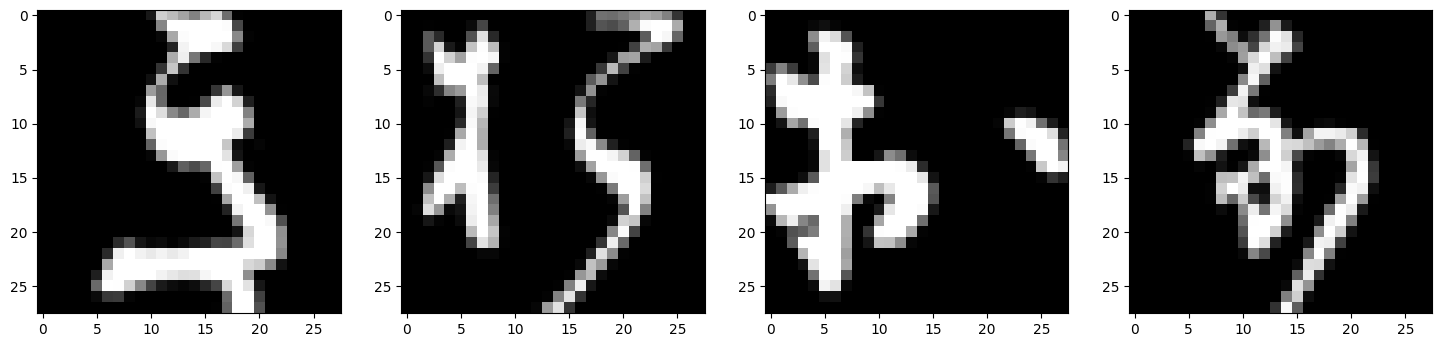

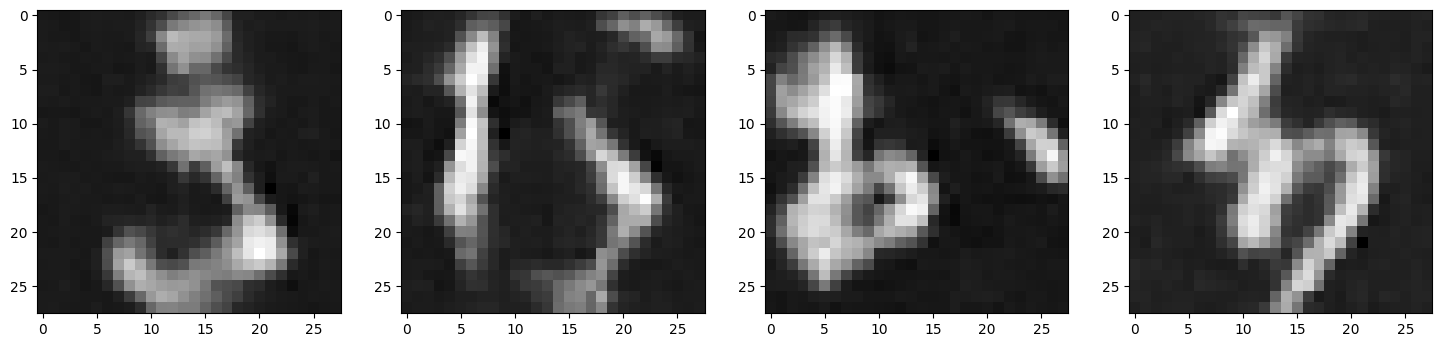

In [7]:
epochs = 50    # 300 epochs sono il limite per il miglioramento del loss.


for epoch in range(epochs):
    autoencoder.train()
    train_loss = 0
    for x,y in iter(trainloader):
        x=x.to(device)
        x_hat=autoencoder(x)
        l=loss_ae(x_hat,x)
        train_loss+=l.item()
        optimizer_ae.zero_grad()
        l.backward()
        optimizer_ae.step()
        
    print("Epoch "+str(epoch+1)+" Training loss:"+str(train_loss / (len(trainloader.dataset))))
        

with torch.no_grad():
    autoencoder.eval()
    test_loss=0 
    for x,y in iter(testloader):
            x=x.to(device)
            x_hat=autoencoder(x)
            l=loss_ae(x_hat,x)
            test_loss+=l.item()
    test_loss /= len(testloader.dataset)
    print("Test set loss:"+str(test_loss))
    display_images(x.cpu(), x_hat.cpu())

---

### Step 3

Definiamo un classificatore lineare che fa uso dell'encoder come "metodo di compressione" per il nostro dataset:

In [8]:
class LinearClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(in_features=d, out_features=16, bias=True)
        self.layer2 = torch.nn.Linear(in_features=16,out_features=10, bias=True)
        self.activation = torch.nn.ELU(alpha=alpha)
        
    def forward(self, x):
        x=self.activation(self.layer1(x))
        x=self.layer2(x)
        return x


classifier = LinearClassifier().to(device)

Definiamo l'optimizer, lo scheduler e la funzione loss del classificatore:

In [9]:
optimizer_cl = torch.optim.SGD(classifier.parameters(), lr=training_rate, momentum=momentum)
scheduler_cl = torch.optim.lr_scheduler.ExponentialLR(optimizer_cl, gamma=gamma)
loss_cl = torch.nn.CrossEntropyLoss()

Definiamo le funzioni per aggiustare il dataset all'architettura (in particolare una funzione per modificare i labels da numeri ad array selettori) e la funzione per l'accuratezza:

In [10]:
def selector(y):
    out = torch.zeros([y.size(dim=0), 10], dtype=torch.float32)
    for idx,k in enumerate(y):
        out[idx][k] = 1.0
    out = out.to(device)
    return out


def get_accuracy(model, dataloader):
    model.eval()
    with torch.no_grad():
        correct=0
        for x, y in iter(dataloader):
            x = x.to(device)
            y = y.to(device)
            x=autoencoder.encoder(x)
            out=model(x)
            correct+=(torch.argmax(out, axis=1)==y).sum()
        return (correct/len(dataloader.dataset)).item()

print(selector(torch.tensor([6])))

tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], device='cuda:0')


Alleniamo il classifier sul dataset (compresso):

Test accuracy:  0.10329999774694443
Epoch:  0
Test accuracy:  0.13459999859333038
Epoch:  1
Test accuracy:  0.21469999849796295
Epoch:  2
Test accuracy:  0.2970999777317047
Epoch:  3
Test accuracy:  0.35349997878074646
Epoch:  4
Test accuracy:  0.3781999945640564
Epoch:  5
Test accuracy:  0.4034000039100647
Epoch:  6
Test accuracy:  0.42899999022483826
Epoch:  7
Test accuracy:  0.46889999508857727
Epoch:  8
Test accuracy:  0.4949999749660492
Epoch:  9
Test accuracy:  0.5156999826431274
Epoch:  10
Test accuracy:  0.5248000025749207
Epoch:  11
Test accuracy:  0.5403000116348267
Epoch:  12
Test accuracy:  0.5633000135421753
Epoch:  13
Test accuracy:  0.5791999697685242
Epoch:  14
Test accuracy:  0.5938999652862549
Epoch:  15
Test accuracy:  0.6049000024795532
Epoch:  16
Test accuracy:  0.6151999831199646
Epoch:  17
Test accuracy:  0.6225000023841858
Epoch:  18
Test accuracy:  0.6284999847412109
Epoch:  19
Test accuracy:  0.6317999958992004
Epoch:  20
Test accuracy:  0.6365999579429626
Epo

Text(0, 0.5, 'MSE Loss')

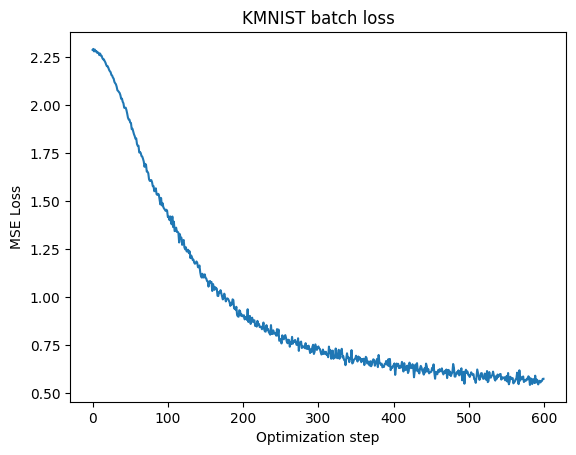

In [11]:
epochs=40

losses=[]
for epoch in range(epochs):
    print("Test accuracy: ", get_accuracy(classifier, testloader))
    classifier.train()
    print("Epoch: ", epoch)
    for x, y in iter(trainloader):
        x = x.to(device)
        x = autoencoder.encoder(x)
        y = y.unsqueeze(1)
        y = selector(y)
        out=classifier(x)
        l=loss_cl(out, y)
        optimizer_cl.zero_grad()
        l.backward()
        optimizer_cl.step()
        losses.append(l.item())
    scheduler_cl.step()
print("Final accuracy: ", get_accuracy(classifier, testloader))

plt.figure()
plt.title("KMNIST batch loss")
plt.plot(losses)
plt.xlabel("Optimization step")
plt.ylabel("MSE Loss")

### Conclusioni

L'autoencoder riesce a comprimere il dataset kMNIST nelle d features calcolate allo Step 1 e un classificatore è capace di catalogare le immagini in base a queste features.<br>
Con 300 epochs sull'autoencoder e 40 epochs sul classificatore è possibile raggiungere un'accuratezza del ~75% in maniera consistente, un risultato decisamente migliore rispetto alla selezione casuale (~10% di accuratezza).